In [1]:
from CartPole_env import CartPole_v1
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from mpl_toolkits import mplot3d
import time 
import math
from tqdm import tqdm
import gymnasium as gym

'''
default parameters of the environment:

- n_obs = 1000 --> number of samples experienced so as to make a discretization over played experience
                rather than assuming to know extrema limit of the states of the environment

- n_split = [4,5,10,12] --> number of split considered for each state in which it is discretized the obs space

- sim = True  --> identify the render mode of the system; if set to False, 'human' is chose

- PLOT_DEBUG = False --> plot the interval of discretization of the states

'''

env = CartPole_v1(n_split=[8,8,8,8])

discretizing the environment ... 
done


In [2]:
a = np.ones((4,10))
print(a*0.5)

[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]


In [21]:
'''
Let's resolve the same environment exploiting the SARSA algorithm, based on the TD(lambda) idea
the exmploration term is set to costant, in order to consider distribution that could vary during time.CLOCK_BOOTTIME
Here the elligibility traces seems to work not so good; it is soething remarkable to take into account.
Maybe a better hyper-parameter tuning could be benefit for the algorithm 
'''

class SARSA_Lambda_learning(CartPole_v1):
    
    def __init__(self, env, epsilon = 0.9, alpha = 0.1, gamma = 0.9, Lambda = 0):  # in this case, we will use alpha as constant parameter for the update
                                                                                          # not alpha = 1/n as it is in the case of the MC implementation
        self.intervals = env.intervals
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Lambda = Lambda
        self.env = env.env
        self.n_split = env.n_split
        self.timestamps = []
        Q_height = 2 # since there are only two possible action 
        Q_width = self.n_split[0]*self.n_split[1]*self.n_split[2]*self.n_split[3]
        self.Q_table = np.random.uniform(low=0, high=1, size=(Q_height, Q_width))
        self.Trace = np.zeros_like(self.Q_table)
        
    def episode_init(self):
        state_raw, info = self.env.reset()
        state = self.state_projection(state_raw)
        return state
    
    def action_choice(self, state):
        if((np.random.uniform(0,100+1)/100) > self.epsilon):
            action = int(np.random.choice([0, 1], size=1, p=[.5, .5]))
        else:
            action = np.argmax(self.Q_table[:, state]) # take the max value associated to the Q_function 
        return action  
    
    def Q_update(self, state, action, new_state, new_action, reward):
        delta = reward - self.Q_table[action][state] + self.gamma*self.Q_table[new_action][new_state]
        self.Trace[action][state] += 1
        indeces = np.argwhere(np.abs(self.alpha*delta*self.Trace) != 0)            
        for index in indeces:   
            self.Q_table[index[0]][index[1]] += self.alpha*(reward - self.Q_table[action][state] + \
                self.gamma*self.Q_table[new_action][new_state])*self.Trace[action][state]
            self.Trace[index[0]][index[1]] = self.gamma*self.Lambda*self.Trace[index[0]][index[1]]
        return
    
    def play_an_episode(self):
        score = 0
        state = self.episode_init()
        action = self.action_choice(state)
        self.Trace = np.zeros_like(self.Q_table)
        while(True):
            score +=1 
            new_state, reward, terminated, truncated, info = self.env.step(action)
            if terminated or truncated: 
                self.timestamps.append(score)
                reward = -10e10
            new_state = self.state_projection(new_state)
            new_action = self.action_choice(new_state)
            self.Q_update(state, action, new_state, new_action, reward)
            if terminated or truncated: 
                break
            action = new_action 
            state = new_state
            
    def run(self, n_episodes=5000):
        for _ in tqdm(range(n_episodes)):
            self.play_an_episode()

100%|██████████| 10000/10000 [01:52<00:00, 88.52it/s]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

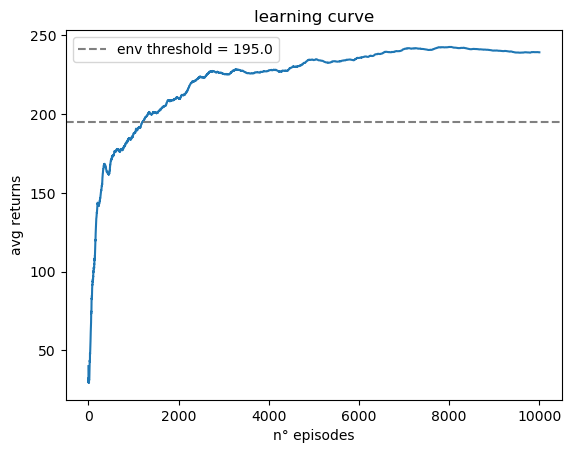

In [22]:
SARSA_agent = SARSA_Lambda_learning(env=env)
SARSA_agent.run(n_episodes=10000)
        
x = np.arange(len(SARSA_agent.timestamps))
accumul = 0
mobile_avg = []
counter = 0
for elem in SARSA_agent.timestamps: 
    counter += 1
    accumul = accumul + (1/counter)*(elem-accumul) 
    mobile_avg.append(accumul)
    
plt.plot(x,mobile_avg)  
plt.axhline(195.0, color='gray', label='env threshold = 195.0', linestyle='--')
plt.xlabel('n° episodes')
plt.ylabel('avg returns') 
plt.title('learning curve')
plt.legend()
plt.plot